In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

# scale our data
from sklearn.preprocessing import StandardScaler

# import metrics
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# import Grid Search
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# time series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
accident_info = pd.read_csv('../uk-road-safety-accidents-and-vehicles/Accident_Information.csv')

/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
vehicle_info = pd.read_csv('../uk-road-safety-accidents-and-vehicles/Vehicle_Information.csv', encoding = "ISO-8859-1")

In [4]:
accident_info.Date = pd.to_datetime(accident_info.Date)
accident_info.shape

(2047256, 34)

In [5]:
dd = accident_info[['Date', 'Accident_Severity']]

In [6]:
df2 = dd.set_index('Date').resample('W').size()

In [7]:
new_df = pd.Series(df2.values, df2.index)

In [8]:
train_size = int(len(new_df) * 0.80)
train, test = new_df[0:train_size], df2[train_size:]

x_train = np.array(train.index).reshape(-1, 1)#.astype('float64')
y_train = np.array(train.values.flatten()).reshape(-1, 1)
x_test = np.array(test.index).reshape(-1, 1)#.astype('float64')
y_test = np.array(test.values.flatten()).reshape(-1, 1)

In [17]:
smoothing_levels = [0.01, 0.03, 0.05, 0.07]
smoothing_slopes = [0.001, 0.002, 0.003, 0.0004]
result_exp_smoothing = []

In [18]:
for idx, i in enumerate(smoothing_levels):
    result_exp_smoothing.append([])
    for j in smoothing_slopes:
        modelb = ExponentialSmoothing(trend='add', endog=train)
        modelb_fit = modelb.fit(smoothing_level=i, smoothing_slope=j)
        y1 = modelb_fit.predict(start='2015-05-31', end='2017-12-31')
        mape1 = np.mean(np.abs((y1.values - test.values) / test.values)) * 100
        result_exp_smoothing[idx].append(mape1)

result_exp_smoothing = np.array(result_exp_smoothing)
print(result_exp_smoothing)


/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


[[7.94082491 7.39918096 7.93983471 9.21640668]
 [7.5549222  7.39483137 7.44616654 8.02694956]
 [7.4806482  7.44288801 7.51410055 7.73829874]
 [7.4781353  7.55497729 7.69359602 7.62129236]]


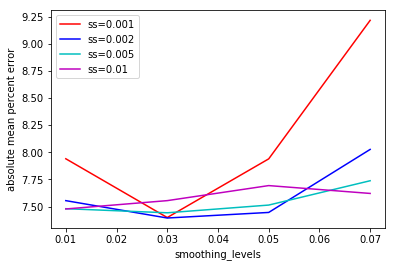

In [25]:
plt.plot(smoothing_levels, result_exp_smoothing[0,:], '-r')
plt.plot(smoothing_levels, result_exp_smoothing[1,:], '-b')
plt.plot(smoothing_levels, result_exp_smoothing[2,:], '-c')
plt.plot(smoothing_levels, result_exp_smoothing[3,:], '-m')
plt.xlabel('smoothing_levels')
plt.ylabel('absolute mean percent error')
plt.legend(['ss=0.001', 'ss=0.002', 'ss=0.005', 'ss=0.01'], loc='upper left')
plt.show()

In [20]:
expo_model = ExponentialSmoothing(trend='add',endog=train)
model_expo_fit = expo_model.fit(smoothing_level=0.03, smoothing_slope=0.002)

In [21]:
y1 = model_expo_fit.predict(start='2015-05-31', end='2017-12-31')

/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [22]:
train.tail()

Date
2015-04-26    2817
2015-05-03    2716
2015-05-10    2538
2015-05-17    2841
2015-05-24    2716
Freq: W-SUN, dtype: int64

In [23]:
mape1 = np.mean(np.abs((y1.values - test.values) / test.values)) * 100

In [24]:
mape1

7.3948313666729995

/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


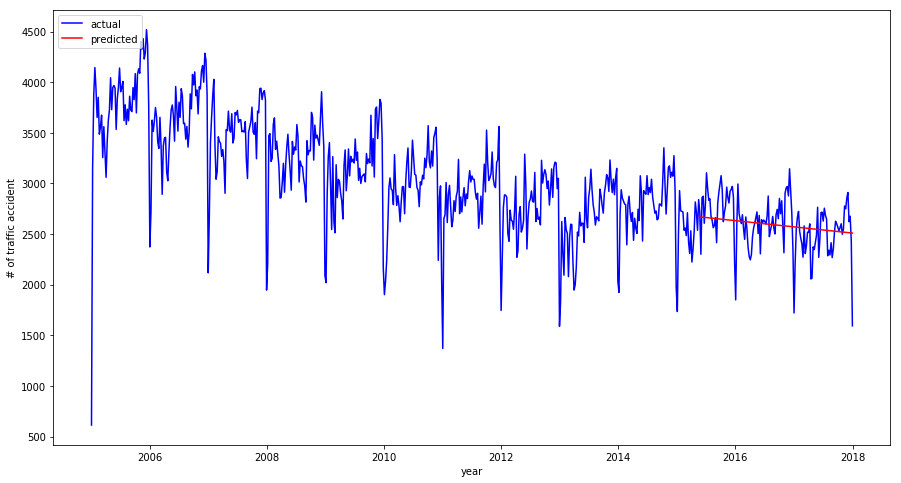

In [26]:
plt.figure(figsize=(15,8))
plt.plot(new_df.index, new_df.values.flatten(), '-b')
plt.plot(x_test, y1.values, '-r')
plt.xlabel('year')
plt.ylabel('# of traffic accident')
plt.legend(['actual', 'predicted'], loc='upper left')
plt.show()

In [120]:
orders = [(2, 0, 3), (2, 0, 4), (2, 0, 5), (2, 0, 6)]
seasonal_orders = [(3,1,2, 3), (3,1,2,4), (3,1,2, 5), (3,1,2, 6)]
result_sarimax_smoothing = []


In [121]:
for idx, i in enumerate(orders):
    print ("i is >>", str(i))
    result_sarimax_smoothing.append([])
    for j in seasonal_orders:
        model = SARIMAX(train,order = i,seasonal_order = j,enforce_stationarity = False, enforce_invertibility = False)
        model_fit = model.fit(disp=False)
        y1 = model_fit.get_prediction(start='2015-05-31', end='2017-12-31')
        mape1 = np.mean(np.abs((y1.predicted_mean - test.values) / test.values)) * 100
        result_sarimax_smoothing[idx].append(mape1)

result_sarimax_smoothing = np.array(result_sarimax_smoothing)
print(result_sarimax_smoothing)

i is >> (2, 0, 3)


/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning

i is >> (2, 0, 4)


/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


i is >> (2, 0, 5)


/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


i is >> (2, 0, 6)


/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[[8.79905583 8.95846197 9.18524271 7.71120865]
 [8.30750577 8.44962629 9.19922946 9.37372974]
 [8.24877842 8.50136159 8.42022728 9.38527703]
 [8.48507845 8.50270231 8.45973132 8.4783346 ]]


In [122]:
result_sarimax_smoothing[0,:]

array([8.79905583, 8.95846197, 9.18524271, 7.71120865])

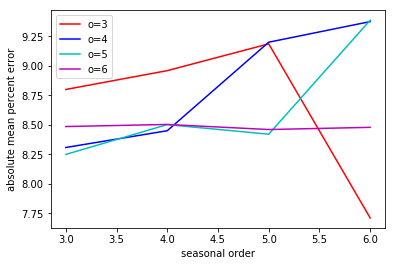

In [124]:
plt.plot(np.array([3,4,5,6]),result_sarimax_smoothing[0,:], '-r')
plt.plot(np.array([3,4,5,6]),result_sarimax_smoothing[1,:], '-b')
plt.plot(np.array([3,4,5,6]),result_sarimax_smoothing[2,:], '-c')
plt.plot( np.array([3,4,5,6]),result_sarimax_smoothing[3,:], '-m')
plt.xlabel('seasonal order')
plt.ylabel('absolute mean percent error')
plt.legend(['o=3', 'o=4', 'o=5', 'o=6'], loc='upper left')
plt.show()

In [125]:
model2 = SARIMAX(train,order = (2,0,3),seasonal_order = (3,1,2,6),enforce_stationarity = False, enforce_invertibility = False)
model_fit2 = model2.fit(disp=False)

/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [126]:
yhat = model_fit2.get_prediction(start='2015-05-31', end='2017-12-31')

/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [127]:
mape2 = np.mean(np.abs((yhat.predicted_mean - test.values) / test.values)) * 100

In [128]:
mape2

7.711208653104554

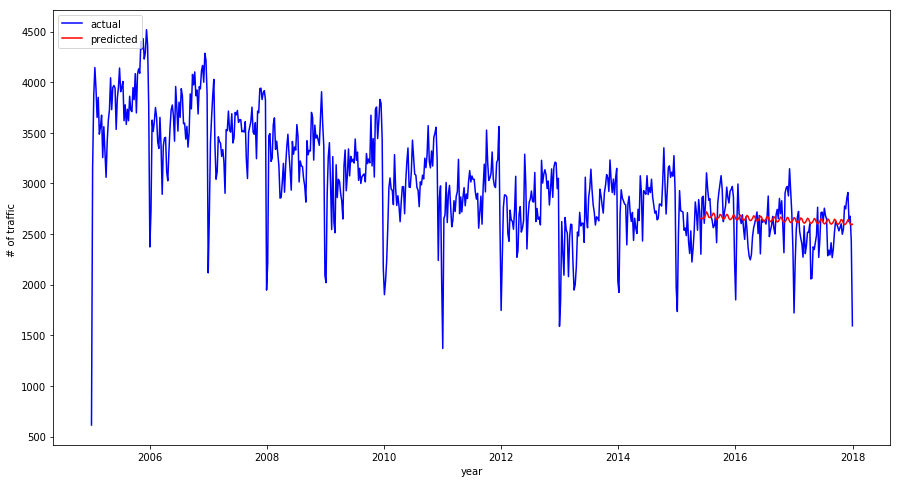

In [129]:
plt.figure(figsize=(15,8))
plt.plot(new_df.index, new_df.values.flatten(), '-b')
plt.plot(x_test, yhat.predicted_mean, '-r')
plt.xlabel('year')
plt.ylabel('# of traffic ')
plt.legend(['actual', 'predicted'], loc='upper left')
plt.show()

In [20]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [21]:
model1 = ARIMA(endog=train, order=(1, 1, 1))

In [22]:
model_fit_1 = model1.fit(disp=False)

In [23]:
yhat_1 = model_fit_1.predict(start='2015-05-31', end='2017-12-31', typ='levels')

/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [24]:
mape3 = np.mean(np.abs((yhat_1 - test.values) / test.values)) * 100

In [25]:
mape3

10.186529701195584

In [28]:
serious = dd[dd['Accident_Severity']=='Serious']
slight = dd[dd['Accident_Severity']=='Slight']

serious = serious.set_index('Date').resample('W').size()
slight = slight.set_index('Date').resample('W').size()

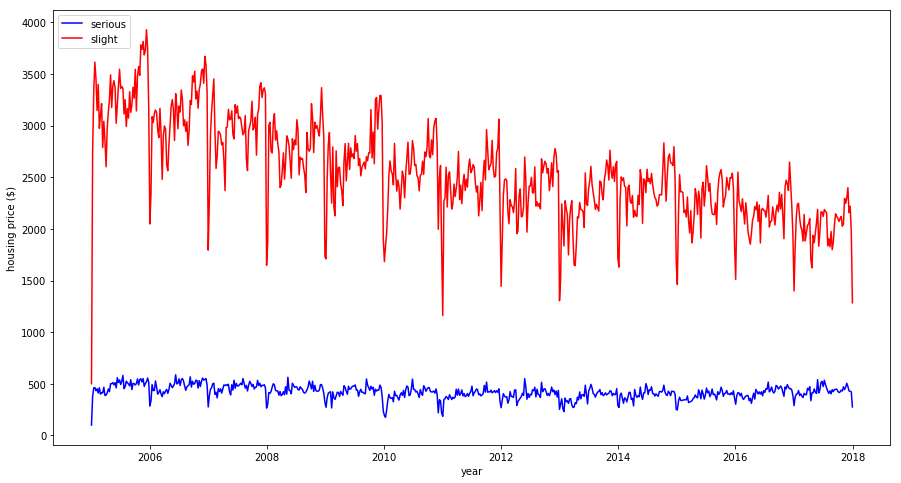

In [34]:
plt.figure(figsize=(15,8))
plt.plot(serious, '-b')
plt.plot(slight, '-r')
plt.xlabel('year')
plt.ylabel('housing price ($)')
plt.legend(['serious', 'slight'], loc='upper left')
plt.show()

In [35]:
serious = dd[dd['Accident_Severity']=='Serious']

(286339, 34)

In [73]:
df = pd.merge(accident_info, vehicle_info, how = 'inner', on = 'Accident_Index')


In [74]:
serious_more = df[df['Accident_Severity']=='Serious']

In [75]:

serious_more.drop_duplicates(subset ="Accident_Index", 
                     keep = False, inplace = True) 
serious_more.shape

/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(121658, 57)

In [76]:
serious_more.head()

,Accident_Index,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,...,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Location.Restricted_Lane,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact,Year_y
18,200501BS00022,A,4.0,Unclassified,0.0,Serious,None,2005-01-08,Saturday,1.0,...,None,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,Car,No,Front,2005
39,200501BS70029,B,450.0,NaN,0.0,Serious,None,2005-02-15,Tuesday,1.0,...,None,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,Motorcycle over 500cc,No,Front,2005
56,200501BS70066,A,315.0,NaN,0.0,Serious,None,2005-03-01,Tuesday,2.0,...,None,No tow/articulation,Did not leave carriageway,0.0,Overtaking static vehicle - offside,1,Motorcycle 50cc and under,No,Nearside,2005
76,200501BS70096,A,3220.0,NaN,0.0,Serious,None,2005-03-16,Wednesday,1.0,...,None,No tow/articulation,Did not leave carriageway,0.0,Overtaking moving vehicle - offside,1,Motorcycle 125cc and under,No,Front,2005
85,200501BS70125,A,315.0,C,0.0,Serious,None,2005-03-17,Thursday,3.0,...,None,No tow/articulation,Did not leave carriageway,0.0,Turning right,2,Bus or coach (17 or more pass seats),No,Front,2005


In [97]:
vehicle_type = serious_more[['Accident_Index','Vehicle_Type']]

In [98]:
v = vehicle_type.groupby('Vehicle_Type')


In [99]:
vehicle_type.index

Int64Index([     18,      39,      56,      76,      85,      98,     118,
                131,     137,     161,
            ...
            2058164, 2058186, 2058247, 2058250, 2058251, 2058262, 2058323,
            2058341, 2058362, 2058363],
           dtype='int64', length=121658)

In [104]:
v.agg(
    {"Accident_Index": len}).sort_values(
    "Accident_Index", ascending=False).head(100).reset_index()

,Vehicle_Type,Accident_Index
0,Car,78438
1,Motorcycle over 500cc,11551
2,Bus or coach (17 or more pass seats),5979
3,Van / Goods 3.5 tonnes mgw or under,5856
4,Motorcycle 125cc and under,5301
5,Taxi/Private hire car,3281
6,Goods 7.5 tonnes mgw and over,3229
7,Motorcycle over 125cc and up to 500cc,2723
8,Motorcycle 50cc and under,1707
9,Goods over 3.5t. and under 7.5t,999


In [107]:
vehicle_age = serious_more[['Accident_Index','Age_of_Vehicle']]
v_a = vehicle_age.groupby('Age_of_Vehicle')
v_a.agg(
    {"Accident_Index": len}).sort_values(
    "Accident_Index", ascending=False).head(20).reset_index()

,Age_of_Vehicle,Accident_Index
0,1.0,10230
1,2.0,8849
2,4.0,8348
3,3.0,8340
4,5.0,7943
5,6.0,7696
6,7.0,7416
7,8.0,7184
8,9.0,6688
9,10.0,6390


In [110]:
vehicle_move = serious_more[['Accident_Index','Vehicle_Manoeuvre']]
v_mm = vehicle_move.groupby('Vehicle_Manoeuvre')
v_mm.agg(
    {"Accident_Index": len}).sort_values(
    "Accident_Index", ascending=False).head(20).reset_index()

,Vehicle_Manoeuvre,Accident_Index
0,Going ahead other,64015
1,Turning right,11303
2,Going ahead right-hand bend,9628
3,Going ahead left-hand bend,7950
4,Moving off,4607
5,Slowing or stopping,4275
6,Turning left,4215
7,Parked,3268
8,Overtaking moving vehicle - offside,2702
9,Reversing,2621


In [111]:
vehicle_make = serious_more[['Accident_Index','make']]
v_m = vehicle_make.groupby('make')
v_m.agg(
    {"Accident_Index": len}).sort_values(
    "Accident_Index", ascending=False).head(20).reset_index()

,make,Accident_Index
0,VAUXHALL,12379
1,FORD,11454
2,HONDA,8138
3,PEUGEOT,6688
4,RENAULT,5802
5,VOLKSWAGEN,5556
6,MERCEDES,4523
7,SUZUKI,4401
8,CITROEN,4165
9,TOYOTA,4131


In [112]:
driver_age = serious_more[['Accident_Index','Age_Band_of_Driver']]
d_a = driver_age.groupby('Age_Band_of_Driver')
d_a.agg(
    {"Accident_Index": len}).sort_values(
    "Accident_Index", ascending=False).head(20).reset_index()

,Age_Band_of_Driver,Accident_Index
0,36 - 45,24513
1,26 - 35,23659
2,46 - 55,20148
3,21 - 25,13880
4,56 - 65,12655
5,16 - 20,11678
6,66 - 75,5637
7,Data missing or out of range,5557
8,Over 75,3820
9,11 - 15,104
